In [1]:
import fsrs_optimizer

timezone = "Europe/Moscow"
next_day_starts_at = 5
revlog_start_date = "2006-10-05"  # YYYY-MM-DD
filter_out_suspended_cards = False
filter_out_flags = []

optimizer = fsrs_optimizer.Optimizer()
optimizer.anki_extract(
    "./Main_27.04.2023.apkg", filter_out_suspended_cards, filter_out_flags
)
optimizer.create_time_series(
    timezone, revlog_start_date, next_day_starts_at, analysis=False
)
optimizer.define_model()
optimizer.pretrain(verbose=False)

Deck file extracted successfully!
revlog.csv saved.


  0%|          | 0/30507 [00:00<?, ?it/s]

Trainset saved.
Pretrain finished!


[]

In [2]:
from torch import Tensor, nn
import torch
from statsmodels.nonparametric.smoothers_lowess import lowess


class ICILoss(nn.Module):
    def __init__(self):
        super(ICILoss, self).__init__()

    def forward(self, predictions: Tensor, labels: Tensor) -> Tensor:
        observation = lowess(
            labels.detach().numpy(),
            predictions.detach().numpy(),
            it=0,
            delta=0.01
            * (max(predictions.detach().numpy()) - min(predictions.detach().numpy())),
            return_sorted=False,
        )
        observation = torch.as_tensor(observation, dtype=torch.float32)
        return torch.abs(predictions - observation)

  0%|          | 0/248083 [00:00<?, ?it/s]

dataset built


train:   0%|          | 0/1756144 [00:00<?, ?it/s]

iteration: 175295
w: [0.3474, 0.3474, 1.592, 90.5314, 5.1065, 1.1319, 0.8291, 0.0377, 1.625, 0.1414, 1.0006, 2.1257, 0.0906, 0.3136, 1.3496, 0.2131, 2.7879]
iteration: 349757
w: [0.3474, 0.3474, 1.592, 90.5314, 5.1059, 1.1308, 0.8321, 0.0316, 1.6237, 0.145, 0.9992, 2.1215, 0.0953, 0.3089, 1.3468, 0.2099, 2.7922]
iteration: 525052
w: [0.3474, 0.3474, 1.592, 90.5314, 5.1046, 1.1286, 0.8334, 0.0275, 1.623, 0.1475, 0.9986, 2.1183, 0.099, 0.3052, 1.3448, 0.2076, 2.795]
iteration: 699514
w: [0.3474, 0.3474, 1.592, 90.5314, 5.102, 1.1256, 0.8332, 0.0248, 1.6236, 0.1487, 0.9993, 2.1167, 0.1012, 0.3031, 1.3442, 0.2072, 2.7986]
iteration: 874809
w: [0.3474, 0.3474, 1.592, 90.5314, 5.0998, 1.1227, 0.8326, 0.0232, 1.6243, 0.1496, 1.0, 2.1156, 0.1027, 0.3017, 1.344, 0.2069, 2.801]
iteration: 1049271
w: [0.3474, 0.3474, 1.592, 90.5314, 5.098, 1.1205, 0.8321, 0.0225, 1.6251, 0.1499, 1.0008, 2.1151, 0.1036, 0.3009, 1.344, 0.2071, 2.8027]
iteration: 1223733
w: [0.3474, 0.3474, 1.592, 90.5314, 5.0966, 1

train:   0%|          | 0/1755200 [00:00<?, ?it/s]

iteration: 175236
w: [0.3474, 0.3474, 1.592, 90.5314, 5.1067, 1.1306, 0.8278, 0.0391, 1.6245, 0.1415, 1.0001, 2.1265, 0.0898, 0.3144, 1.3507, 0.2123, 2.7839]
iteration: 349580
w: [0.3474, 0.3474, 1.592, 90.5314, 5.1072, 1.1292, 0.8307, 0.0335, 1.622, 0.1457, 0.9978, 2.123, 0.0939, 0.3103, 1.3487, 0.2077, 2.7846]
iteration: 524816
w: [0.3474, 0.3474, 1.592, 90.5314, 5.1068, 1.127, 0.8323, 0.0298, 1.6207, 0.1485, 0.9966, 2.1202, 0.0971, 0.3071, 1.3475, 0.2041, 2.7847]
iteration: 699160
w: [0.3474, 0.3474, 1.592, 90.5314, 5.1051, 1.1241, 0.8325, 0.0275, 1.621, 0.1495, 0.997, 2.1189, 0.0989, 0.3054, 1.3474, 0.2029, 2.7857]
iteration: 874396
w: [0.3474, 0.3474, 1.592, 90.5314, 5.1038, 1.1217, 0.8327, 0.0261, 1.6213, 0.1504, 0.9974, 2.1183, 0.0999, 0.3044, 1.3478, 0.2019, 2.7858]
iteration: 1048740
w: [0.3474, 0.3474, 1.592, 90.5314, 5.103, 1.1201, 0.8327, 0.0254, 1.6216, 0.1508, 0.9978, 2.1178, 0.1006, 0.3037, 1.3482, 0.2013, 2.7864]
iteration: 1223084
w: [0.3474, 0.3474, 1.592, 90.5314, 5.

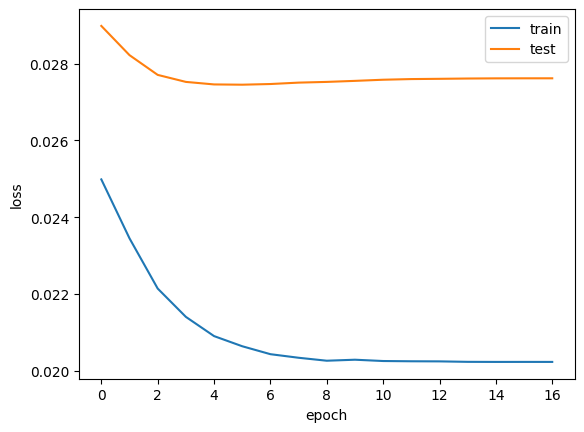

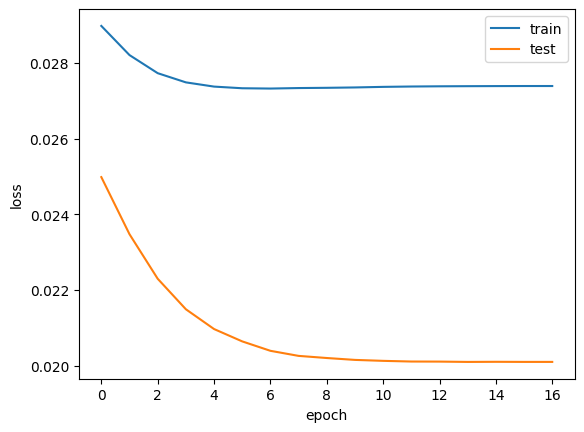

In [3]:
from fsrs_optimizer import Trainer, lineToTensor, StratifiedGroupKFold
import numpy as np

lr: float = 1e-4
n_epoch: int = 16
n_splits: int = 2
batch_size: int = 1024
verbose: bool = True

dataset = optimizer.dataset
dataset["tensor"] = dataset.progress_apply(
    lambda x: lineToTensor(list(zip([x["t_history"]], [x["r_history"]]))[0]),
    axis=1,
)
dataset["group"] = dataset["r_history"] + dataset["t_history"]

w = []
plots = []
sgkf = StratifiedGroupKFold(n_splits=n_splits)
for train_index, test_index in sgkf.split(dataset, dataset["i"], dataset["group"]):
    train_set = dataset.iloc[train_index].copy()
    test_set = dataset.iloc[test_index].copy()
    trainer = Trainer(
        train_set,
        test_set,
        optimizer.init_w,
        n_epoch=n_epoch,
        lr=lr,
        batch_size=batch_size,
    )
    trainer.loss_fn = ICILoss()
    w.append(trainer.train(verbose=verbose))
    if verbose:
        plots.append(trainer.plot())

w = np.array(w)
avg_w = np.round(np.mean(w, axis=0), 4)
optimizer.w = avg_w.tolist()

Loss before training: 0.4219
Loss after training: 0.4197
R-squared: 0.8393
RMSE: 0.0358
MAE: 0.0243
ICI: 0.0231
E50: 0.0172
E90: 0.0421
EMax: 0.3055
[0.22158764 0.73230277]

Last rating: 1
R-squared: 0.5215
RMSE: 0.0603
MAE: 0.0551
ICI: 0.0537
E50: 0.0579
E90: 0.0821
EMax: 0.2155
[0.27513237 0.6328983 ]

Last rating: 2
R-squared: 0.7713
RMSE: 0.0430
MAE: 0.0382
ICI: 0.0349
E50: 0.0325
E90: 0.0421
EMax: 0.3062
[0.17622346 0.76119567]

Last rating: 3
R-squared: 0.8125
RMSE: 0.0376
MAE: 0.0247
ICI: 0.0225
E50: 0.0130
E90: 0.0433
EMax: 0.2918
[0.24299162 0.72486765]

Last rating: 4
R-squared: -2.6787
RMSE: 0.0605
MAE: 0.0367
ICI: 0.0361
E50: 0.0252
E90: 0.0829
EMax: 0.3759
[0.63235657 0.36292871]


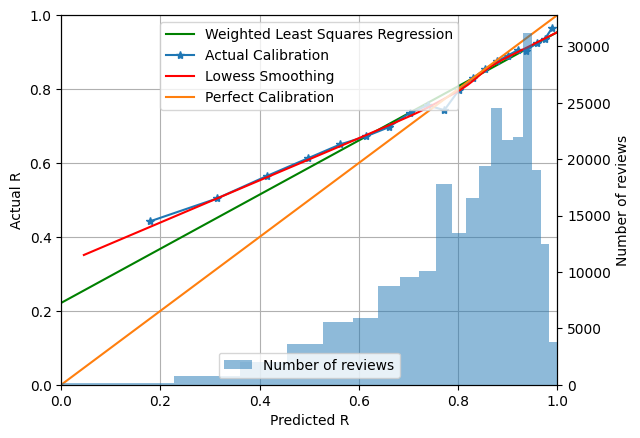

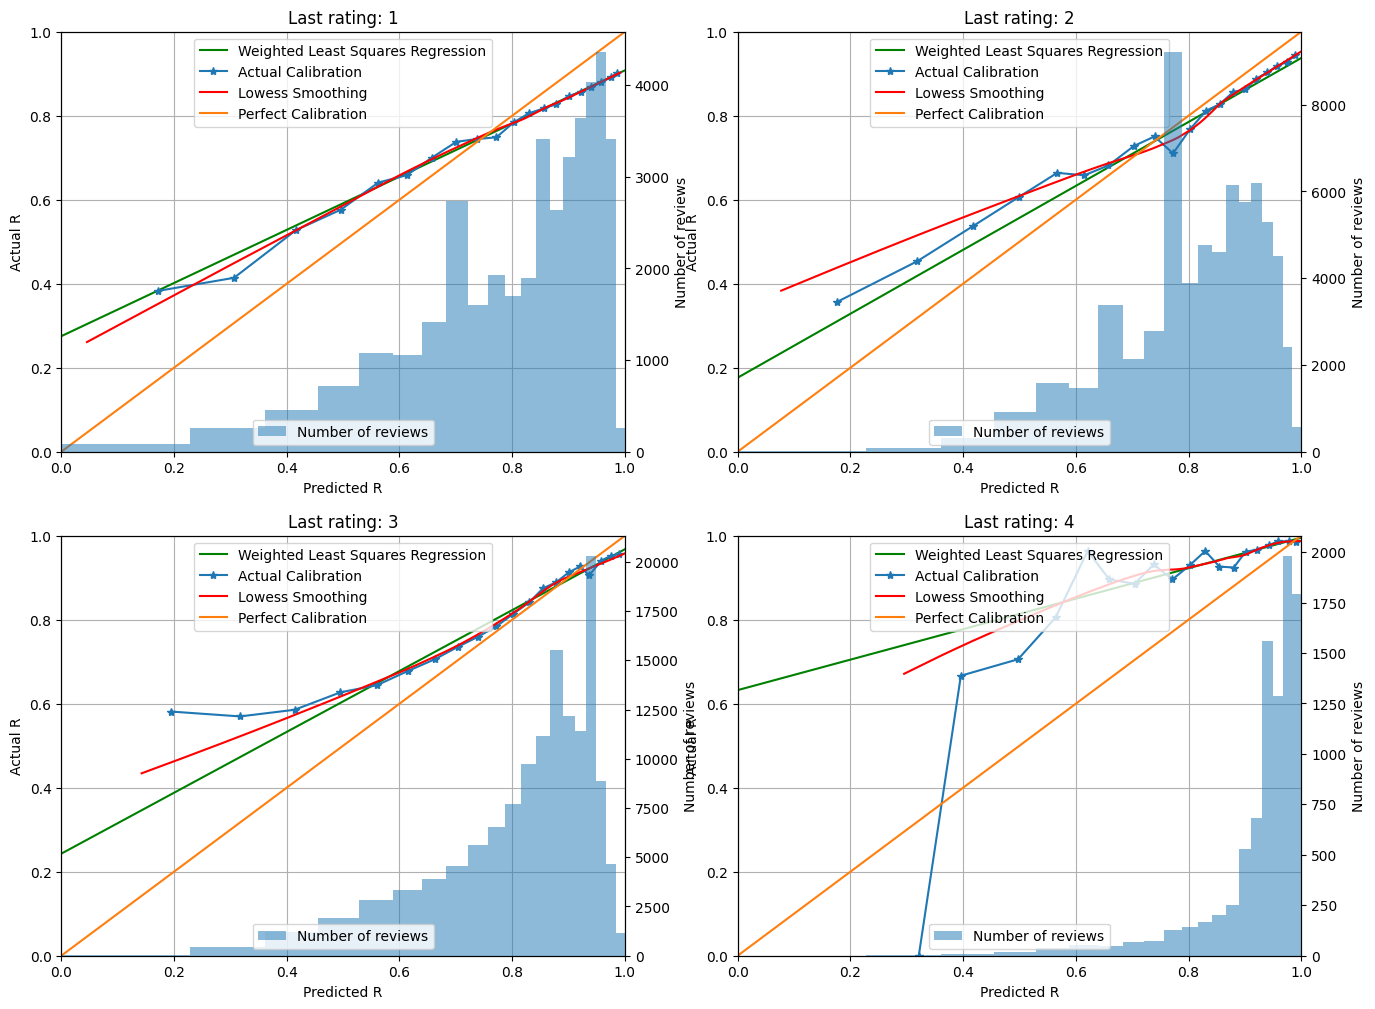

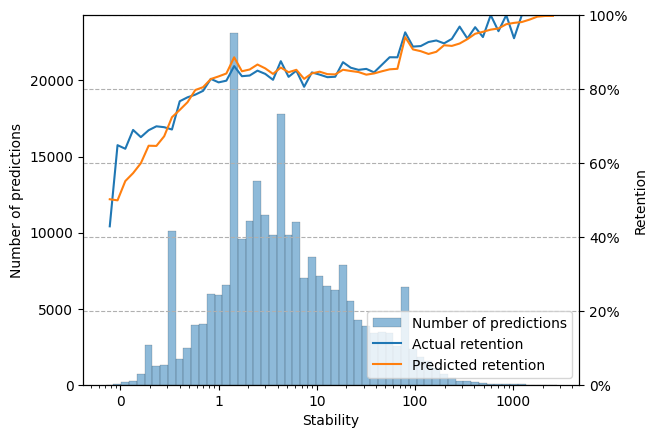

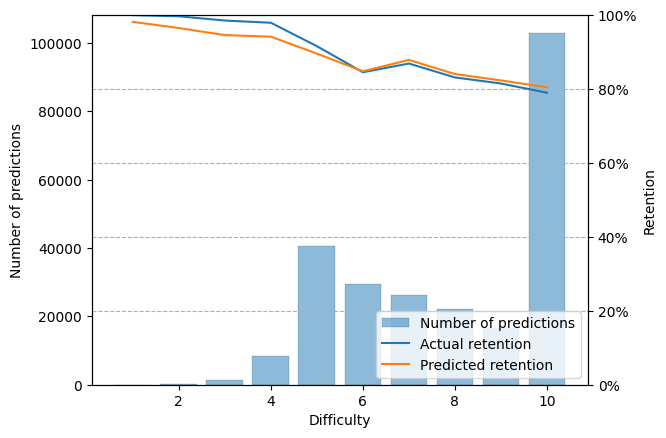

In [4]:
loss_before, loss_after = optimizer.evaluate()
print(f"Loss before training: {loss_before:.4f}")
print(f"Loss after training: {loss_after:.4f}")
metrics, figures = optimizer.calibration_graph()